# IMPORTS

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize, ToPILImage, InterpolationMode
import torch.optim as optim

c:\Users\anike\anaconda3\envs\data-science\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATA LOADER

In [8]:
# DEFINE CUSTOM CLASS
class DepthDataset(Dataset):
    def __init__(self, X_path, y_path, img_size):
        self.img_size = img_size

        # SET TRAINING TYPE, TRANSFORMS, PREPROCESSING
        # self.transforms = transforms
        # self.preprocessing = preprocessing
        
        self.images_paths = []
        self.depth_paths = []
        cities = os.listdir(X_path)[:10]
        for city in cities:
            imgs = os.listdir(os.path.join(X_path, city))
            for img in imgs:
                X = os.path.join(X_path, city, img)
                self.images_paths.append(X)
                name = img.rsplit("_", 1)[0] + "_disparity.png"
                y = os.path.join(y_path, city, name)
                self.depth_paths.append(y)
    
    def __getitem__(self, i):

            image = Image.open(self.images_paths[i])
            depth = Image.open(self.depth_paths[i])
            
            # if image.mode == "L":
            # image = image.convert("RGB")
                
            ## APPLY TRANSFORM
            image = Compose([Resize((self.img_size, self.img_size), interpolation=InterpolationMode.BICUBIC), ToTensor()])(image)
            depth = Compose([Resize((self.img_size, self.img_size), interpolation=InterpolationMode.BICUBIC), ToTensor()])(depth)

            
            depth = torch.clamp(depth, min=0, max=22500)
            depth = depth / 100

            
            ## APPLY PREPROCESSING
            # if self.preprocessing:
                # image = Compose([Normalize(mean = [0.485, 0.456, 0.406],
                                            # std = [0.229, 0.224, 0.225])])(image)
            
            return image, depth
                
    def __len__(self):
        return len(self.images_paths)

In [9]:
train_dataset = DepthDataset("depth_X\\train", "depth_y\\train", 224)
train_loader = DataLoader(train_dataset, batch_size=16)

# IMAGE TESTER

In [4]:
for X, y in train_loader:
    break 

In [123]:
X.shape, y.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32, 1, 256, 256]))

In [124]:
y = y.ravel()

In [125]:
y.shape

torch.Size([2097152])

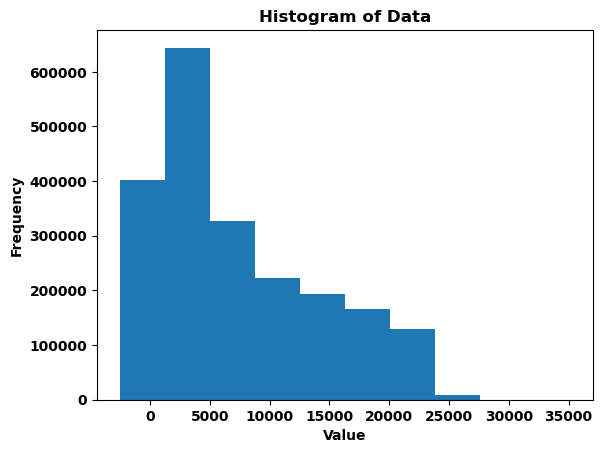

In [126]:
import matplotlib.pyplot as plt

# Create the histogram with customization
plt.hist(y)

# Add titles and labels
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

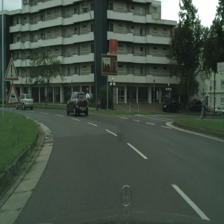

In [5]:
ToPILImage()(X[0])

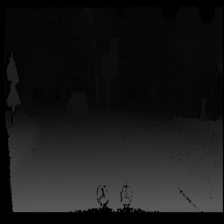

In [6]:
ToPILImage()(y[0].int()*100)

In [117]:
print(y.max())

tensor(351.5700)


# MODEL

In [10]:
class ReassembleLayer(nn.Module):
    def __init__(self, embed_dim, s, new):
        super(ReassembleLayer, self).__init__()
        self.new = new
        self.embed_dim = embed_dim
        self.project = nn.Conv2d(self.embed_dim, self.new, kernel_size=1, stride=1, padding=0)
        if s == 4:
            self.s = nn.ConvTranspose2d(self.new, self.new, kernel_size=3, stride=4, output_padding=1)
        elif s == 8:
            self.s = nn.ConvTranspose2d(self.new, self.new, kernel_size=3, stride=2, padding=1, output_padding=1)
        elif s == 16:
            self.s = nn.Conv2d(self.new, self.new, kernel_size=3, stride=1, padding=1)
        else:
            self.s = nn.Conv2d(self.new, self.new, kernel_size=3, stride=2, padding=1)

    def forward(self, tokens):
        # read
        cls = tokens[:, 0, :]
        tokens = tokens[:, 1:, :]
        b, n, d = tokens.size()
        h = w = int(n ** 0.5)
        cls =  cls.view(-1, 1, cls.shape[1])
        cls = cls.expand(-1, n, -1)
        tokens = tokens + cls
        cls = None

        # concatenate
        x = tokens.permute(0, 2, 1).reshape(b, self.embed_dim, h, w)

        # resample
        x = self.project(x)
        x = self.s(x)

        return x


class FusionBlock(nn.Module):
    def __init__(self, in_channels):
        super(FusionBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x, skip_connection):
        x = x + skip_connection
        x = self.upsample(x)
        return x

In [11]:
class DPT(nn.Module):

    def __init__(self, model_type='base', patch_size=16, num_classes=1000, new=256):
        super().__init__()
        self.new = new
        self.img_size = 224

        # Define ViT backbone using timm
        if model_type == 'base':
            self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
        elif model_type == 'large':
            self.vit = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=num_classes)
        elif model_type == 'hybrid':
            self.vit = timm.create_model('vit_base_resnet50_224_in21k', pretrained=True, num_classes=num_classes)
        else:
            raise ValueError("Unsupported model_type. Choose from 'base', 'large', or 'hybrid'.")

        # for param in self.vit.parameters():
            # param.requires_grad = False

        self.num_classes = num_classes
        self.patch_size = patch_size

        # Reassemble layers to get the feature maps at different scales
        self.reassemble_layers = nn.ModuleList([
            ReassembleLayer(embed_dim=768 if model_type == 'base' else 1024, s=4, new=new),   # 56
            ReassembleLayer(embed_dim=768 if model_type == 'base' else 1024, s=8, new=new),   # 28
            ReassembleLayer(embed_dim=768 if model_type == 'base' else 1024, s=16,new=new),   # 14
            ReassembleLayer(embed_dim=768 if model_type == 'base' else 1024, s=32,new=new)    # 7
        ])

        self.fusion_blocks = nn.ModuleList([
            FusionBlock(new),
            FusionBlock(new),
            FusionBlock(new),
            FusionBlock(new),
        ])

        self.output_head = nn.Sequential(
            nn.Conv2d(new, new//2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(new//2, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
            nn.ReLU(True),
        )

    def forward(self, x):
        b, c, h, w = x.size()

        tokens = self.vit.patch_embed(x)  # Initial embedding

        # Add the [CLS] token to the beginning of the token sequence
        cls_token = self.vit.cls_token.expand(b, -1, -1)  # Shape: [batch_size, 1, embedding_dim]
        tokens = torch.cat((cls_token, tokens), dim=1)  # Shape: [batch_size, num_patches + 1, embedding_dim]

        # Positional embedding
        tokens += self.vit.pos_embed

        specific_tokens = []
        for i, layer in enumerate(self.vit.blocks):
            if (i+1) % 3 == 0:
              tokens = layer(tokens)
              specific_tokens.append(tokens)

        for i in range(0, len(specific_tokens)):
            specific_tokens[i] = self.vit.norm(specific_tokens[i])

        reassembled_features = []
        for i, reassemble_layer in enumerate(self.reassemble_layers):
            reassembled_features.append(reassemble_layer(specific_tokens[i]))
        reassembled_features.append(torch.zeros([b, self.new, self.img_size//32, self.img_size//32]).cuda())

        x = reassembled_features[-1]
        for i in range(len(self.fusion_blocks)):
            x = self.fusion_blocks[i](x, reassembled_features[-(i+2)])

        x = self.output_head(x)

        return x

# DEFINE

In [12]:
# Example usage
model = DPT(model_type='base', num_classes=1, new=256).cuda()  # For example, 21 classes for segmentation
opt = optim.Adam([
    {'params': model.vit.parameters(), 'lr': 1e-5},  # Encoder/backbone
    {'params': model.reassemble_layers.parameters(), 'lr': 1e-4},  # Decoder's reassemble layers
    {'params': model.fusion_blocks.parameters(), 'lr': 1e-4},  # Decoder's fusion blocks
    {'params': model.output_head.parameters(), 'lr': 1e-4},  # Decoder's output head
])
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')
cri = nn.MSELoss().cuda()

In [11]:
input_tensor = torch.randn(64, 3, 224, 224).cuda()
model(input_tensor).shape

torch.Size([64, 1, 224, 224])

# TRAIN

In [13]:
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = []
    s = 0
    for X, y in train_loader:
        inputs, labels = X.cuda(), y.cuda()
        opt.zero_grad()
        outputs = model(inputs)
        loss = torch.sqrt(cri(outputs, labels))
        loss.backward()
        opt.step()
        # scheduler.step(int(loss))
        running_loss.append(loss.item() * X.shape[0])
        s += X.shape[0]
    loss = sum(running_loss) / s
    print("Epoch: {} Loss: {}".format(epoch, loss))

Epoch: 0 Loss: 49.336194181608796
Epoch: 1 Loss: 33.976022100837184
Epoch: 2 Loss: 33.19249389612911
Epoch: 3 Loss: 32.71251229273982
Epoch: 4 Loss: 32.25139251993199
Epoch: 5 Loss: 31.764389726418973
Epoch: 6 Loss: 31.283077253312808
Epoch: 7 Loss: 30.899193731536688
Epoch: 8 Loss: 30.576514269614524
Epoch: 9 Loss: 30.373771232276358
Epoch: 10 Loss: 30.130445835615344
Epoch: 11 Loss: 29.84404752418243
Epoch: 12 Loss: 29.64670191488388
Epoch: 13 Loss: 29.419509359233178
Epoch: 14 Loss: 29.125093406792708
Epoch: 15 Loss: 28.966391884267537
Epoch: 16 Loss: 28.671402774673126
Epoch: 17 Loss: 28.456077398049263
Epoch: 18 Loss: 28.322001387270838
Epoch: 19 Loss: 27.973951810452657
Epoch: 20 Loss: 27.72290398549978
Epoch: 21 Loss: 27.46228730553659
Epoch: 22 Loss: 27.23982572722074
Epoch: 23 Loss: 27.05559358163818
Epoch: 24 Loss: 26.788173846510155
Epoch: 25 Loss: 26.51521296162544
Epoch: 26 Loss: 26.164570527526358
Epoch: 27 Loss: 25.898396628560786
Epoch: 28 Loss: 25.407612837235224
Epoch

# TEST

In [14]:
o = model(X.cuda())

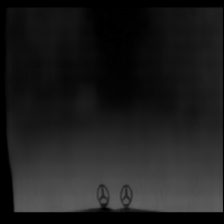

In [15]:
ToPILImage()(o[4].int()*100)

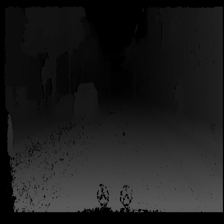

In [18]:
ToPILImage()(y[4].int()*100)